# Import Modules

In [93]:
import dataset as ds
import config as cfg

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
tf.keras.utils.set_random_seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.metrics import Precision, Recall

from clearml import Task
import clearml
clearml.browser_login()


# ClearML
https://app.clear.ml/dashboard

# Import Dataset

In [28]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test Parameters

In [52]:
project_name= cfg.PROJECT_NAME + '/tf_clf'
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
project_dir = f'{cfg.CLF_PROJECT_DIR}/{dataset_name}/'
class_names = cfg.CLF_CLASS_NAMES

#epochs = 20
zoom_factor = 1.5


_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


In [53]:
# Pre-processing to AID classification

ds.pre_process_dataset_for_classification(dataset_dir, zoom_factor)


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\26227.jpg: Expected y_max for bbox (0.36195600000000006, 0.7324, 0.764684, 1.000886, 0) to be in the range [0.0, 1.0], got 1.000886.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\64758.jpg: Expected y_max for bbox (0.060445000000000026, 0.645367, 0.7276929999999999, 1.0901990000000001, 0) to be in the range [0.0, 1.0], got 1.0901990000000001.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\68377.jpg: Expected y_min for bbox (0.29860800000000004, -0.02214949999999999, 0.8637140000000001, 0.3545875, 0) to be in the range [0.0, 1.0], got -0.02214949999999999.


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\68377.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\26227.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\64758.txt
Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


In [55]:
augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/497 [00:00<?, ?it/s]

Copying files:   0%|          | 0/497 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/248 [00:00<?, ?it/s]

In [56]:
ds.reorganize_dataset_for_keras(dataset_dir)

Moving images in train:   0%|          | 0/497 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/745 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/100 [00:00<?, ?it/s]

# Image Classifier Approach 2

In [75]:
train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

batch_size = 32
img_height = 256
img_width = 256

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),
    shuffle=True)

train_aug_data = tf.keras.utils.image_dataset_from_directory(
    train_aug_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),
    shuffle=True)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),    
    shuffle=True)

class_names = train_data.class_names
print(class_names)



Found 497 files belonging to 3 classes.
Found 745 files belonging to 3 classes.
Found 100 files belonging to 3 classes.
['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90']


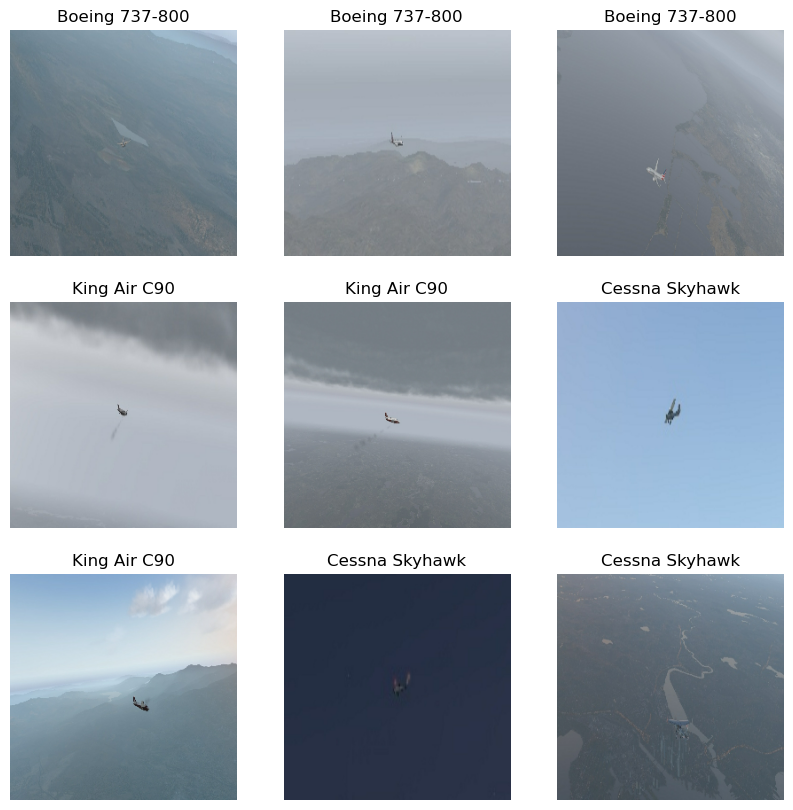

In [76]:
# test visualise 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_aug_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [77]:
def one_hot_enc(image, label):
    return image, tf.one_hot(label, len(class_names))

train_data = train_data.map(one_hot_enc)
train_aug_data = train_aug_data.map(one_hot_enc)
valid_data = valid_data.map(one_hot_enc)


In [78]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 3)


In [79]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_aug_data = train_aug_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)


In [113]:
# get list of validation labels for evaluation
validation_labels = []
for images, labels in valid_data:
    validation_labels.append(labels.numpy())

validation_labels = np.concatenate(validation_labels)

In [80]:
# model

def get_model(): 
  num_classes = len(class_names)

  model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
   #Conv2D(32, (3,3), activation='relu'),
   #MaxPooling2D(),
   #Conv2D(32, (3,3), activation='relu'),
   #MaxPooling2D(),
   #Conv2D(16, (3,3), activation='relu'),
   #MaxPooling2D(),
   #Dropout(0.2),
   #Flatten(),
   #Dense(256, activation='relu'),      
    Dense(num_classes, activation='softmax')
 
  ])
  
  """model = Sequential()
    model.add(Input(shape=(256,256,3)))  # Add an Input layer to specify the input shape
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes """

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

  #model.summary()
  
  return model


In [81]:
epochs = 20

In [82]:
# train pure

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-pure-eps:{epochs}-zf:{zoom_factor}")
logger = task.get_logger()

# clearml hyperparameters
hyper_params = {'epochs': epochs, 'zoom_factor': zoom_factor, 'batch_size': batch_size, 'img_height': img_height, 'img_width': img_width, 'class_names': class_names}
task.connect(hyper_params)

model = None
train_hst = None

model = get_model()

# trian model
train_hst = model.fit(
    train_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data,
    callbacks=[tensorboard_callback])

y_pred = model.predict(valid_data)

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])
    logger.report_scalar('precision', 'train', iteration=epoch, value=train_hst.history['precision'][epoch])
    logger.report_scalar('recall', 'train', iteration=epoch, value=train_hst.history['recall'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
    logger.report_scalar('precision', 'validation', iteration=epoch, value=train_hst.history['val_precision'][epoch])
    logger.report_scalar('recall', 'validation', iteration=epoch, value=train_hst.history['val_recall'][epoch])

# close task
task.close()

ClearML Task: created new task id=6be89f9d5bfd442a9e7d295ebc0a4168
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/6be89f9d5bfd442a9e7d295ebc0a4168/output/log
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.3890 - loss: 3.0282 - precision: 0.3301 - recall: 0.2251 - val_accuracy: 0.3300 - val_loss: 1.1037 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.3674 - loss: 1.0939 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3400 - val_loss: 1.0967 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.3044 - loss: 1.1012 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3300 - val_loss: 1.0984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.3239 - loss: 1.0987 - precision: 0.0000e+00 - recall: 0.

In [83]:
# train aug

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-aug-eps:{epochs}-zf:{zoom_factor}")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs, 'zoom_factor': zoom_factor, 'batch_size': batch_size, 'img_height': img_height, 'img_width': img_width, 'class_names': class_names}
task.connect(hyper_params)

model_aug = None
train_aug_hst = None

# reset model from previous test
model_aug = get_model()

# trian model
train_aug_hst = model_aug.fit(
    train_aug_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data, 
    callbacks=[tensorboard_callback])

y_pred_aug = model_aug.predict(valid_data)

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_aug_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_aug_hst.history['accuracy'][epoch])
    logger.report_scalar('precision', 'train', iteration=epoch, value=train_aug_hst.history['precision'][epoch])
    logger.report_scalar('recall', 'train', iteration=epoch, value=train_aug_hst.history['recall'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_aug_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_aug_hst.history['val_accuracy'][epoch])
    logger.report_scalar('precision', 'validation', iteration=epoch, value=train_aug_hst.history['val_precision'][epoch])
    logger.report_scalar('recall', 'validation', iteration=epoch, value=train_aug_hst.history['val_recall'][epoch])
    
    
# close task
task.close()

ClearML Task: created new task id=ca3f1ab961a5419290f6bcdf9563a288
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/ca3f1ab961a5419290f6bcdf9563a288/output/log
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.3431 - loss: 2.9172 - precision: 0.2622 - recall: 0.1170 - val_accuracy: 0.3400 - val_loss: 1.0964 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.3488 - loss: 1.0985 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3100 - val_loss: 1.0989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.3528 - loss: 1.0978 - precision: 0.3400 - recall: 9.3139e-04 - val_accuracy: 0.3300 - val_loss: 1.0992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.3503 - loss: 1.0979 - precision: 0.6800 - recall: 0.0015 - v

In [84]:
task.close()

# Evaluation

In [102]:
# Evaluating pure dataset accuracy performance

# train and val accuracies
pure_accuracies = (train_hst.history['accuracy'])
pure_val_accuracies = train_hst.history['val_accuracy']

# train and val average accuracies
pure_average_accuracy = round(np.mean(pure_accuracies),3)
pure_average_val_accuracy = round(np.mean(pure_val_accuracies),3)
print("Pure average accuracy: ", pure_average_accuracy)
print("Pure average val accuracy: ", pure_average_val_accuracy)
print()

# standard deviation of train and val accuracies
pure_std_accuracy = round(np.std(pure_accuracies),3)
pure_std_val_accuracy = round(np.std(pure_val_accuracies),3)
print("Pure std accuracy: ", pure_std_accuracy)
print("Pure std val accuracy: ", pure_std_val_accuracy)
print()

# best train and val accuracies
pure_best_accuracy = round(np.max(pure_accuracies),3)
pure_best_val_accuracy = round(np.max(pure_val_accuracies),3)
print("Pure best accuracy: ", pure_best_accuracy)
print("Pure best val accuracy: ", pure_best_val_accuracy)
print()

# last epoch accuracies
pure_last_epoch_accuracy = round(pure_accuracies[-1],3)
pure_last_epoch_val_accuracy = round(pure_val_accuracies[-1],3)
print("Pure last epoch accuracy: ", pure_last_epoch_accuracy)
print("Pure last epoch val accuracy: ", pure_last_epoch_val_accuracy)
print()



Pure average accuracy:  0.401
Pure average val accuracy:  0.397

Pure std accuracy:  0.078
Pure std val accuracy:  0.091

Pure best accuracy:  0.6
Pure best val accuracy:  0.6

Pure last epoch accuracy:  0.6
Pure last epoch val accuracy:  0.59



In [105]:
# Evaluating augmented dataset accuracy performance

# train and val accuracies
aug_accuracies = train_aug_hst.history['accuracy']
aug_val_accuracies = train_aug_hst.history['val_accuracy']
#print("Augmented accuracies: ", aug_accuracies)
#print("Augmented val accuracies: ", aug_val_accuracies)

# train and val average accuracies
aug_average_accuracy = round(np.mean(aug_accuracies),3)
aug_average_val_accuracy = round(np.mean(aug_val_accuracies),3)
print("Augmented average accuracy: ", aug_average_accuracy)
print("Augmented average val accuracy: ", aug_average_val_accuracy)
print()

# standard deviation of train and val accuracies
aug_std_accuracy = round(np.std(aug_accuracies), 3)
aug_std_val_accuracy = round(np.std(aug_val_accuracies), 3)
print("Augmented std accuracy: ", aug_std_accuracy)
print("Augmented std val accuracy: ", aug_std_val_accuracy)
print()

# best train and val accuracies
aug_best_accuracy = round(np.max(aug_accuracies), 3)
aug_best_val_accuracy = round(np.max(aug_val_accuracies),3)
print("Augmented best accuracy: ", aug_best_accuracy)
print("Augmented best val accuracy: ", aug_best_val_accuracy)
print()

# last epoch accuracies
aug_last_epoch_accuracy = round(aug_accuracies[-1],3)
aug_last_epoch_val_accuracy = round(aug_val_accuracies[-1],3)
print("Augmented last epoch accuracy: ", aug_last_epoch_accuracy)
print("Augmented last epoch val accuracy: ", aug_last_epoch_val_accuracy)
print()


Augmented average accuracy:  0.581
Augmented average val accuracy:  0.526

Augmented std accuracy:  0.205
Augmented std val accuracy:  0.134

Augmented best accuracy:  0.878
Augmented best val accuracy:  0.7

Augmented last epoch accuracy:  0.878
Augmented last epoch val accuracy:  0.68



In [115]:

# Area under the ROC curve - pure
y_true = validation_labels
#y_pred = model.predict(valid_data)

auc = round(roc_auc_score(y_true, y_pred),3)
print("Pure AUC: ", auc)

# Area under the ROC curve - augmented
#y_pred_aug = model_aug.predict(valid_data)
auc_Aug = round(roc_auc_score(y_true, y_pred_aug),3)
print("Augmented AUC: ", auc_Aug)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Pure AUC:  0.714
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Augmented AUC:  0.806


In [121]:
# Max validation F1 score - pure
pure_val_precision = train_hst.history['val_precision']
pure_val_recall = train_hst.history['val_recall']

f1_scores = []
for p, r in zip(pure_val_precision, pure_val_recall):
    if p + r > 0:  
        f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)

# Get the maximum F1 score and its corresponding epoch
max_f1_score = max(f1_scores)
max_f1_epoch = f1_scores.index(max_f1_score)
print("Max F1 score - pure: ", round(max_f1_score,3), " at epoch: ", max_f1_epoch)

# Max validation F1 score - augmented
aug_val_precision = train_aug_hst.history['val_precision']
aug_val_recall = train_aug_hst.history['val_recall']

f1_scores = []
for p, r in zip(aug_val_precision, aug_val_recall):
    if p + r > 0:  
        f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)

# Get the maximum F1 score and its corresponding epoch
max_f1_score = max(f1_scores)
max_f1_epoch = f1_scores.index(max_f1_score)
print("Max F1 score - aug: ", round(max_f1_score,3), " at epoch: ", max_f1_epoch)

Max F1 score - pure:  0.386  at epoch:  19
Max F1 score - aug:  0.697  at epoch:  18


In [130]:
# pure loss

pure_loss = train_hst.history['loss']
pure_val_loss = train_hst.history['val_loss']

# minimum val loss
min_loss = min(pure_val_loss)
print("Min loss - pure: ", round(min_loss,3))

# Difference between train and val for last N epochs 
N = 10

pure_average_loss_lastN = sum(pure_loss[-N:]) / N
pure_val_average_loss_lastN = sum(pure_val_loss[-N:]) / N

pure_std_loss_lastN = np.std(pure_loss[-N:])
pure_val_std_loss_lastN = np.std(pure_val_loss[-N:])

# difference between train and val loss
diff_av = round(pure_val_average_loss_lastN - pure_average_loss_lastN,3)
diff_std = round(pure_val_std_loss_lastN - pure_std_loss_lastN,3)

print(f"Diff avrg loss - last {N} epcohs - pure: ", round(diff_av,3))
#print(f"Diff std loss - last {N} epcohs - pure: ", round(diff_std,3))




Min loss - pure:  0.976
Diff avrg loss - last 10 epcohs - pure:  0.003


In [131]:
# augmented loss

aug_loss = train_aug_hst.history['loss']
aug_val_loss = train_aug_hst.history['val_loss']

# minimum val loss
min_loss_aug = min(aug_val_loss)
print("Min loss - aug: ", round(min_loss_aug,3))

# Difference between train and val for last N epochs 

aug_average_loss_lastN = sum(aug_loss[-N:]) / N
aug_val_average_loss_lastN = sum(aug_val_loss[-N:]) / N

aug_std_loss_lastN = np.std(aug_loss[-N:])
aug_val_std_loss_lastN = np.std(aug_val_loss[-N:])

# difference between train and val loss
diff_av = round(aug_val_average_loss_lastN - aug_average_loss_lastN,3)
diff_std = round(aug_val_std_loss_lastN - aug_std_loss_lastN,3)

print(f"Diff avrg loss - last {N} epcohs - aug: ", diff_av)
#print(f"Diff std loss - last {N} epcohs - aug: ", diff_std)

Min loss - aug:  0.829
Diff avrg loss - last 10 epcohs - aug:  0.438


# Class Specific Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


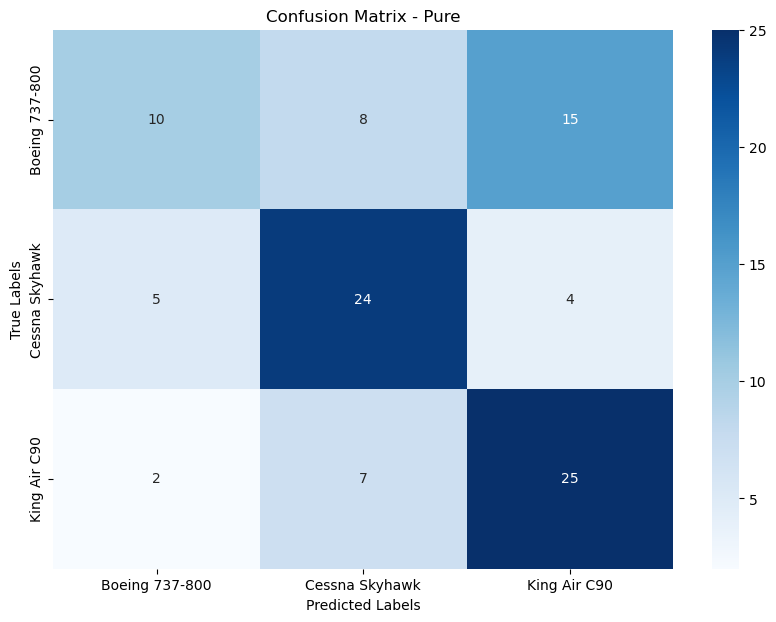

In [138]:
# Clasification matrix - pure
y_true = validation_labels

# Check if y_true needs conversion from one-hot to class labels
if len(y_true[0]) > 1:  # This assumes y_true is a list of arrays
    y_true = [np.argmax(label) for label in y_true]
else:
    y_true = [label for sublist in y_true for label in sublist]  # Flatten the list if necessary

# Convert predictions from probabilities to class indices if not already done
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting using seaborn for a nicer-looking confusion matrix
plt.figure(figsize=(10, 7))
# ['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90']
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90'], yticklabels=['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Pure')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


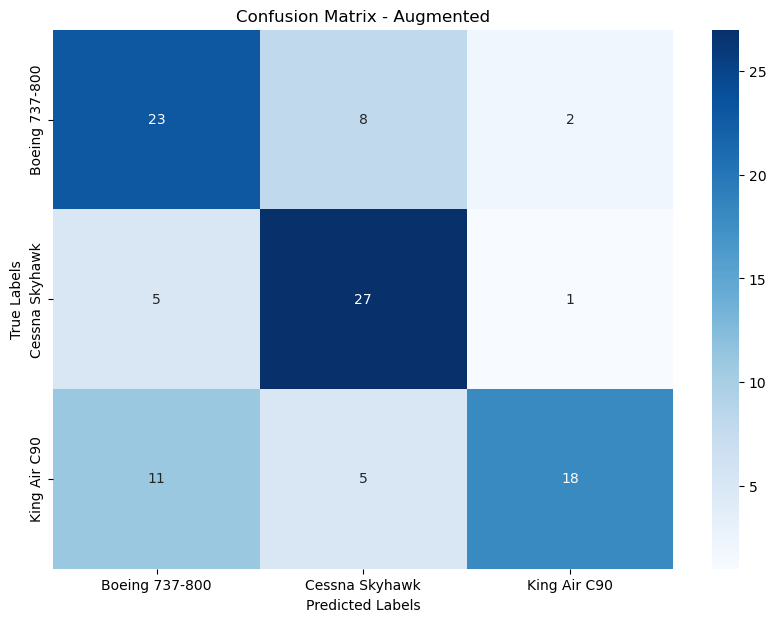

In [139]:
# Clasification matrix - augmented
y_true = validation_labels

# Check if y_true needs conversion from one-hot to class labels
if len(y_true[0]) > 1:  # This assumes y_true is a list of arrays
    y_true = [np.argmax(label) for label in y_true]
else:
    y_true = [label for sublist in y_true for label in sublist]  # Flatten the list if necessary

# Convert predictions from probabilities to class indices if not already done
y_pred_aug = model_aug.predict(valid_data)
y_pred_aug = np.argmax(y_pred_aug, axis=1)

# Generate the confusion matrix
conf_matrix_aug = confusion_matrix(y_true, y_pred_aug)

# Plotting using seaborn for a nicer-looking confusion matrix
plt.figure(figsize=(10, 7))
# ['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90']
sns.heatmap(conf_matrix_aug, annot=True, fmt='g', cmap='Blues', xticklabels=['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90'], yticklabels=['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Augmented')
plt.show()

# Old Image Classifier (redundant)

In [85]:
## check GPU available
#gpus = tf.config.list_physical_devices('GPU')
#print(gpus)
#
## limit vram usage
#for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [86]:
# directories of train, train-aug and validation
#train_dir = os.path.join(dataset_dir,'images','train')
#train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
#valid_dir = os.path.join(dataset_dir,'images','valid')
#
## load datasets using keras
#train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                         batch_size=32,
#                                                        seed=42, 
#                                                         shuffle=True)
#train_aug_data = tf.keras.utils.image_dataset_from_directory(train_aug_dir,
#                                                             batch_size=32,
#                                                             seed=42,
#                                                             shuffle=True)
#valid_data = tf.keras.utils.image_dataset_from_directory(valid_dir,
#                                                         batch_size=32,
#                                                         seed=42,
#                                                         shuffle=True)
#
## scale images between 0 and 1
#train_data = train_data.map(lambda x,y: (x/255, y))
#train_aug_data = train_aug_data.map(lambda x,y: (x/255, y))
#valid_data = valid_data.map(lambda x,y: (x/255, y))

In [87]:
# TEST - use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
#train_iterator = train_data.as_numpy_iterator()
#train_batch = train_iterator.next()

In [88]:
# TEST - visualise images with class labels
#train_batch = train_iterator.next()
#fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
#for idx, img in enumerate(train_batch[0][:4]):
#    ax[idx].imshow(img)
#    ax[idx].title.set_text(train_batch[1][idx])


In [89]:
# use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
#train_data.as_numpy_iterator().next()
#train_aug_data.as_numpy_iterator().next()
#valid_data.as_numpy_iterator().next()
#
#print("done")

In [90]:
# create a CNN model
#def get_model():
#
#    tf.random.set_seed(42)
#    # model architecture - Also try ResNet50 or VGG16
#    model = Sequential()
#    model.add(Input(shape=(256,256,3)))  # Add an Input layer to specify the input shape
#    model.add(Conv2D(32, (3,3), activation='relu')) 
#    model.add(MaxPooling2D())
#    model.add(Conv2D(32, (3,3), activation='relu'))
#    model.add(MaxPooling2D())
#    model.add(Conv2D(16, (3,3), activation='relu'))
#    model.add(MaxPooling2D())
#    model.add(Flatten())
#    model.add(Dense(256, activation='relu'))
#    model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes
#
#    model.compile(optimizer='adam', 
#                loss='sparse_categorical_crossentropy', 
#                metrics=['accuracy'])
#    #model.summary()
#    
#    return model


In [91]:
# train pure

# local logs directory
#logs_dir=cfg.CLF_PROJECT_DIR
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
#
##connect to clearml
#task = Task.init(project_name=project_name, task_name=f"{dataset_name}-pure-eps:{epochs}-zf:{zoom_factor}")
#logger = task.get_logger()
#
## clearml hyperparameters
#hyper_params = {'epochs': epochs}
#task.connect(hyper_params)
#
#model = get_model()
#
## trian model
#train_hst = model.fit(
#    train_data, 
#    epochs=hyper_params['epochs'], 
#    validation_data=valid_data, 
#    callbacks=[tensorboard_callback])
#
## send metrics to clearML
#for epoch in range(epochs):
#    # Log training metrics
#    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
#    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])
#
#    # Log validation metrics
#    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
#    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
#
## close task
#task.close()



In [92]:
# train aug

# local logs directory
#logs_dir=cfg.CLF_PROJECT_DIR
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
#
##connect to clearml
#task = Task.init(project_name=project_name, task_name=f"{dataset_name}-aug-eps:{epochs}-zf:{zoom_factor}")
#logger = task.get_logger()
#
#
## clearml hyperparameters
#hyper_params = {'epochs': epochs}
#task.connect(hyper_params)
#
## reset model from previous test
#model_aug = get_model()
#
## trian model
#train_aug_hst = model.fit(
#    train_aug_data, 
#    epochs=hyper_params['epochs'], 
#    validation_data=valid_data, 
#    callbacks=[tensorboard_callback])
#
## send metrics to clearML
#for epoch in range(epochs):
#    # Log training metrics
#    logger.report_scalar('loss', 'train', iteration=epoch, value=train_aug_hst.history['loss'][epoch])
#    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_aug_hst.history['accuracy'][epoch])
#
#    # Log validation metrics
#    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_aug_hst.history['val_loss'][epoch])
#    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_aug_hst.history['val_accuracy'][epoch])
#    
## close task
#task.close()

